In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score,  mean_squared_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

#from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

label = LabelEncoder()


### 1. Data loading and Preparation

In [2]:
train_df = pd.read_csv("Train.csv")
#make a copy
train_df_cp=train_df

In [3]:
train_df.head()

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5
0,ID_0038MG0B,2020-04-23 17:00:00+03:00,USEmbassy,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0
1,ID_008ASVDD,2020-02-23 19:00:00+03:00,USEmbassy,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0
2,ID_009ACJQ9,2021-01-23 04:00:00+03:00,Nakawa,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7
3,ID_00IGMAQ2,2019-12-04 09:00:00+03:00,USEmbassy,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0
4,ID_00P76VAQ,2019-10-01 01:00:00+03:00,USEmbassy,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0


In [4]:
#First lets look at the data in the columns of the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10932 entries, 0 to 10931
Data columns (total 18 columns):
ID                 10932 non-null object
created_at         10932 non-null object
site               10932 non-null object
pm2_5              10932 non-null float64
pm10               10932 non-null float64
s2_pm2_5           10932 non-null float64
s2_pm10            10932 non-null float64
humidity           10926 non-null float64
temp               10915 non-null float64
lat                10932 non-null float64
long               10932 non-null float64
altitude           10932 non-null int64
greenness          10932 non-null int64
landform_90m       10932 non-null int64
landform_270m      10932 non-null int64
population         10932 non-null int64
dist_major_road    10932 non-null int64
ref_pm2_5          10932 non-null float64
dtypes: float64(9), int64(6), object(3)
memory usage: 1.5+ MB


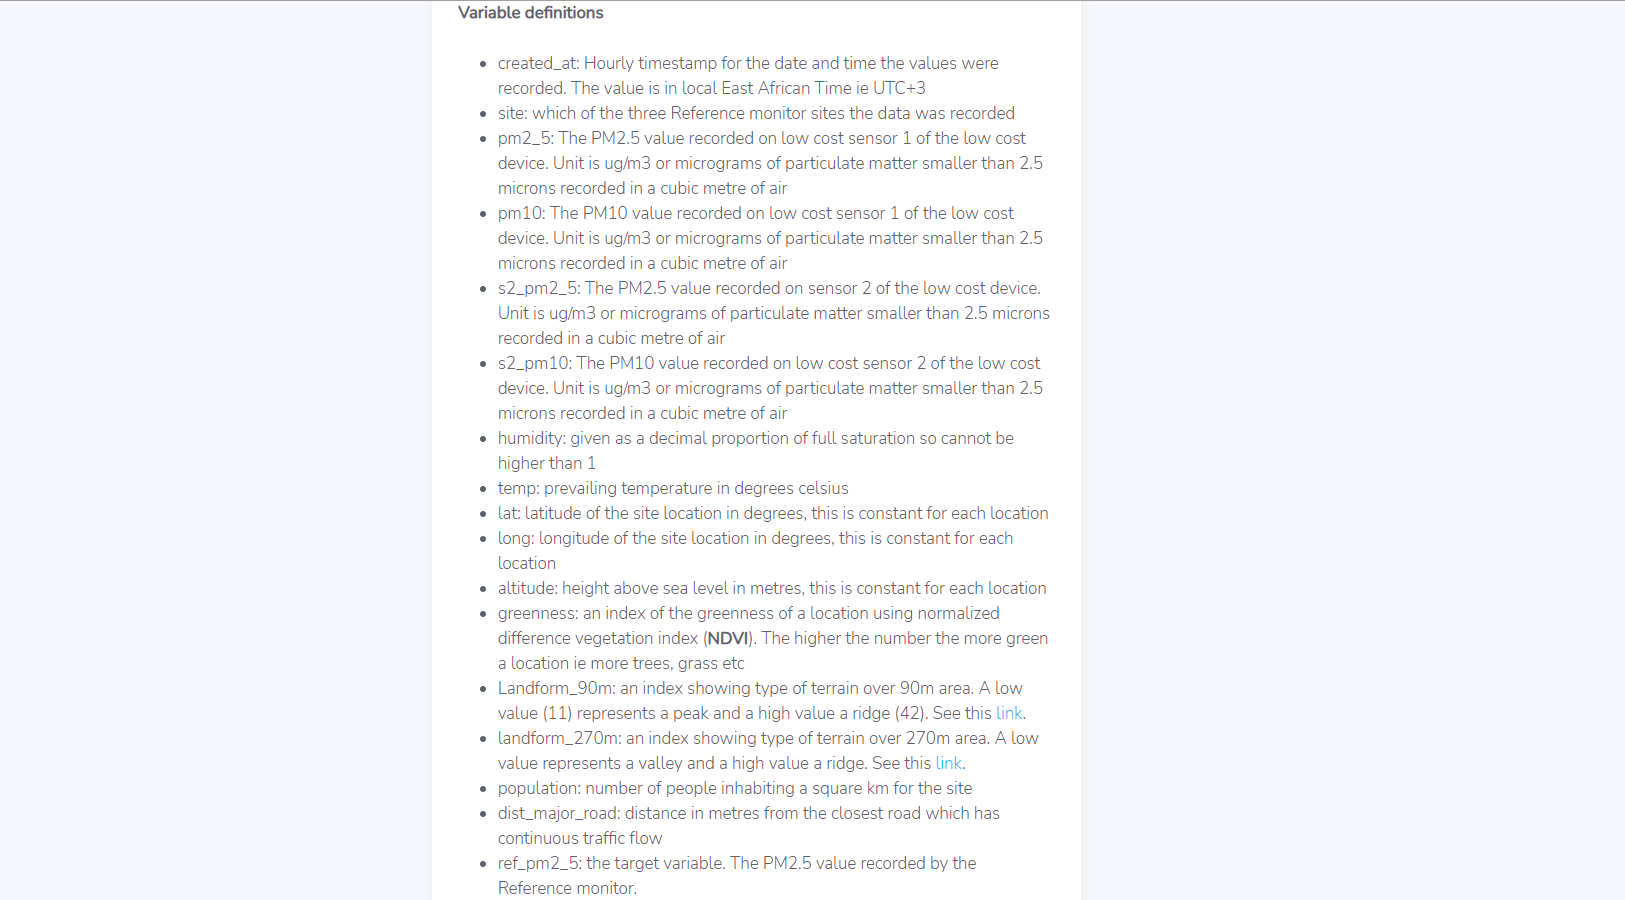

In [5]:
#Check for mising values
train_df.isnull().any()

ID                 False
created_at         False
site               False
pm2_5              False
pm10               False
s2_pm2_5           False
s2_pm10            False
humidity            True
temp                True
lat                False
long               False
altitude           False
greenness          False
landform_90m       False
landform_270m      False
population         False
dist_major_road    False
ref_pm2_5          False
dtype: bool

#### Insights from the data
1. There are three non numeric variables i.e ID, created at and site. 
2. Columns 'humidity' and 'temp' have some mising values so we have to deal with that.

#### Filling in the missing data
Let's fill in the missing data

In [6]:
train_df=train_df.fillna(0)

#### Addressing the non-numeric features

In [7]:

non_numeric_features = train_df.dtypes[train_df.dtypes == 'object'].index
print('Categorical features', len(non_numeric_features))

print("Categorical features", train_df[non_numeric_features].columns)

Categorical features 3
Categorical features Index(['ID', 'created_at', 'site'], dtype='object')


In [8]:
## First lets work on the 'site' column
#X_enc = non_numeric_features.copy()
site_enc= pd.get_dummies(train_df.site, prefix='site',)
train_df = train_df.drop(['site','ID','created_at'],axis=1)
train_df_new = pd.concat([train_df,site_enc], axis=1)

In [9]:
train_df_new


,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,ref_pm2_5,site_Makerere,site_Nakawa,site_USEmbassy
0,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,25.0,0,0,1
1,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,68.0,0,0,1
2,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,149.7,0,1,0
3,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,54.0,0,0,1
4,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,39.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10927,51.888605,65.367442,51.297209,65.013721,0.810000,19.883333,0.299255,32.592686,1199,4374,21,14,6834,130,77.0,0,0,1
10928,11.872500,12.523864,13.069091,13.886591,0.990417,17.775000,0.299255,32.592686,1199,4374,21,14,6834,130,22.0,0,0,1
10929,38.274773,48.724545,39.802045,45.335227,0.774000,23.341667,0.299255,32.592686,1199,4374,21,14,6834,130,34.0,0,0,1
10930,35.646154,42.889231,34.193846,40.942308,0.807917,22.816667,0.333501,32.568561,1233,6340,21,28,8518,475,34.8,1,0,0


### 2. Data Visualisation

To begin data visualization, lets look at the target variables, then identify the categorical features and numerical features. From the hackathon description, we are told that the target variable is the reference value. A reference monitor is a very heavy (30kg) static machine that requires mains electricity and secure mounting.

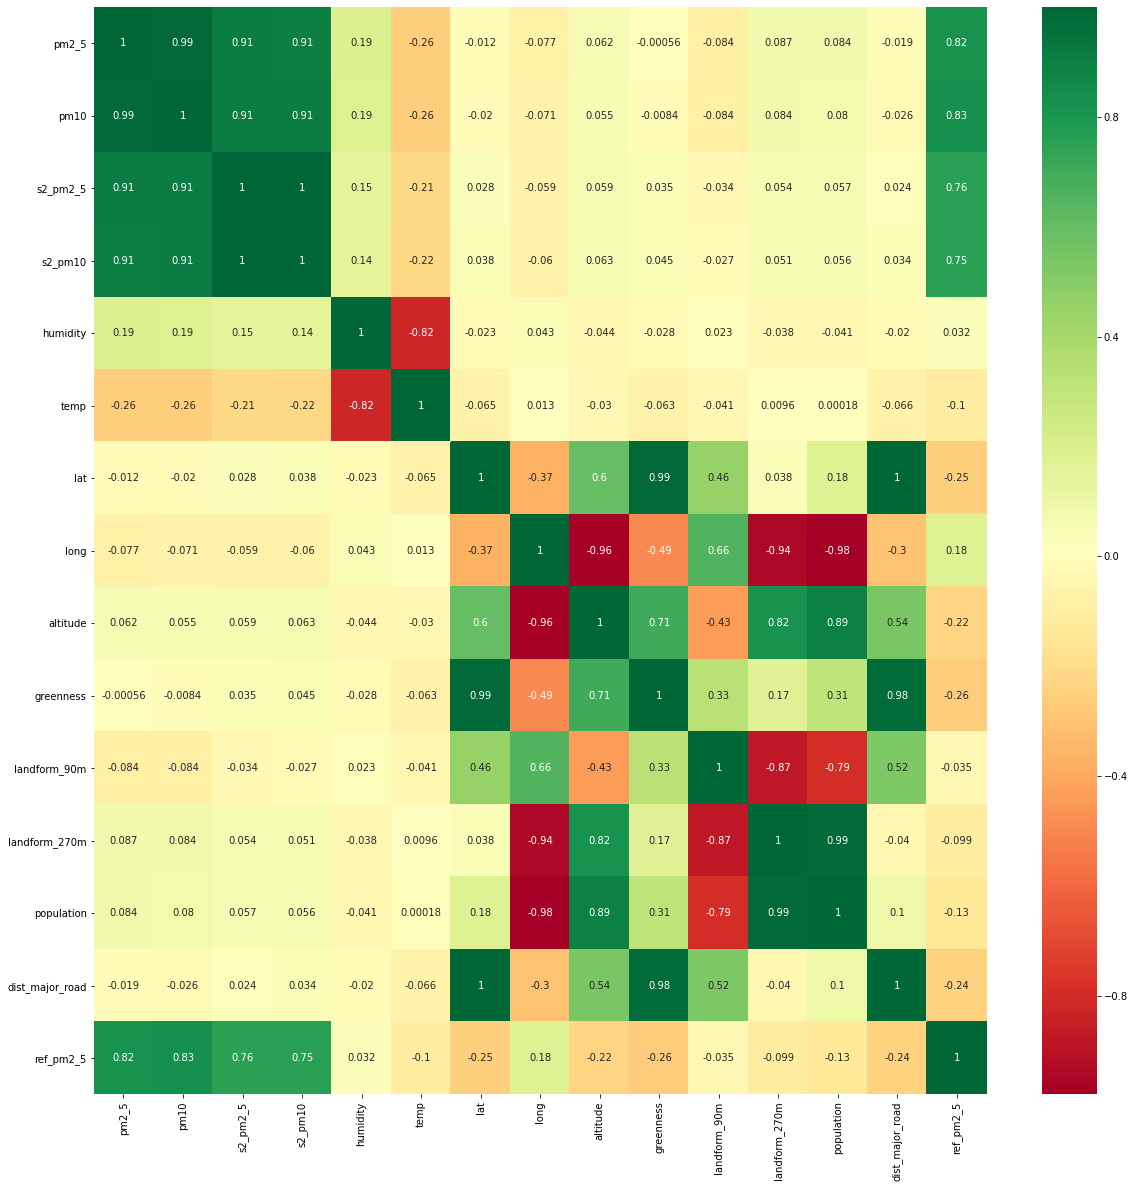

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
#data = pd.read_csv("D://Blogs//train.csv")
#X = data.iloc[:,0:20]  #independent columns
#y = data.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = train_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(train_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We can see that there are more 0's than 1's. This shows an imbalance in the dataset. We might have to address that. 

### 3. Model Preparation

Divide the dataset into training and testing portions.

In [10]:
y_train_set = train_df_new["ref_pm2_5"] # the label/target column
X_train_set = train_df_new.drop('ref_pm2_5', axis=1)# feature columns
#X_train_set = train_df_new[["pm2_5","pm10","s2_pm2_5","s2_pm10", "long", "humidity"]]

In [11]:
X_train_set

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,site_Makerere,site_Nakawa,site_USEmbassy
0,6.819048,7.313810,6.794048,7.838333,0.807417,22.383333,0.299255,32.592686,1199,4374,21,14,6834,130,0,0,1
1,57.456047,67.883488,55.643488,70.646977,0.712417,25.350000,0.299255,32.592686,1199,4374,21,14,6834,130,0,0,1
2,170.009773,191.153636,165.308636,191.471591,0.907833,20.616667,0.331740,32.609510,1191,5865,31,-11,4780,500,0,1,0
3,49.732821,61.512564,0.000000,0.000000,0.949667,21.216667,0.299255,32.592686,1199,4374,21,14,6834,130,0,0,1
4,41.630455,51.044545,41.725000,51.141364,0.913833,18.908333,0.299255,32.592686,1199,4374,21,14,6834,130,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10927,51.888605,65.367442,51.297209,65.013721,0.810000,19.883333,0.299255,32.592686,1199,4374,21,14,6834,130,0,0,1
10928,11.872500,12.523864,13.069091,13.886591,0.990417,17.775000,0.299255,32.592686,1199,4374,21,14,6834,130,0,0,1
10929,38.274773,48.724545,39.802045,45.335227,0.774000,23.341667,0.299255,32.592686,1199,4374,21,14,6834,130,0,0,1
10930,35.646154,42.889231,34.193846,40.942308,0.807917,22.816667,0.333501,32.568561,1233,6340,21,28,8518,475,1,0,0


#### Apply SMOTE
 This is to address the imbalance

#### SMOTE

In [12]:
#smt = SMOTE()
#X_train_set, y_train_set = smt.fit_sample(X_train_set, y_train_set)
#y_train.value_counts()

In [13]:

#PCA
#pca = PCA(n_components=7)
#train_df_up=pca.fit_transform(X_train_set)
#x_test=pca.fit_transform(x_test)
#train_df_updated =pd.DataFrame(train_df_up)



#### Spliting the data
- It's always advisable to set aside some data for validating how your model performs. They are various methods of cross validation. In this case we use train-test split module from sklearn.

- Try other methods of cross-validation, Kfold, Stratified Fold, etc.

In [14]:
# spliting the data, 70% train set and 30% val set
#train_set, val_set = train_test_split(train_df,
                           #    test_size=0.30, random_state=2)
#train_set, val_set = train_test_split(train_df_updated,
                             # test_size=0.30, random_state=2)
    
X_train, X_valid, y_train, y_valid = train_test_split(X_train_set, y_train_set,
                                                     test_size=0.3,
                                                      random_state=2)


In [15]:
#train_df.age.max()

In [16]:
#train_set.shape

In [17]:
#val_set.shape

In [18]:
#train_set.head(5)

##### Model
- Create a binary classifier model for training purposes.
- Using simple RandomForest Classifier

In [42]:

xg =XGBRegressor(n_estimators=500, learning_rate=0.1)
#xg.fit(X_train, y_train, early_stopping_rounds=5, 
  #           eval_set=[(X_valid, y_valid)], verbose=False)

#test the model with validation data
# = model.predict(OH_X_valid)
#y_testing = xg.predict(X_valid)

#from sklearn.metrics import mean_absolute_error
#print("Mean Absolute Error : " + str(np.sqrt(mean_absolute_error(y_testing, y_valid))))


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from numpy import absolute
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(xg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 7.647 (0.476)


In [35]:
xg.fit(X_train, y_train, early_stopping_rounds=5, 
            eval_set=[(X_valid, y_valid)], verbose=False)


C:\Users\Emmanuella\Anaconda3\envs\tensorflow_env\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[01:44:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [46]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]
eval_metric = ["rmse","error"]
%time xg.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[01:53:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:57.9378	validation_0-error:-52.2675	validation_1-rmse:56.9839	validation_1-error:-51.4373
[1]	validation_0-rmse:52.7522	validation_0-error:-52.2675	validation_1-rmse:51.9211	validation_1-error:-51.4373
[2]	validation_0-rmse:48.1189	validation_0-error:-52.2675	validation_1-rmse:47.373	validation_1-error:-51.4373
[3]	validation_0-rmse:43.996	validation_0-error:-52.2675	validation_1-rmse:43.3601	validation_1-error:-51.4373
[4]	validation_0-rmse:40.3303	validation_0-error:-52.2675	validation_1-rmse:39.7956	validation_1-error:-51.4373
[5]	validation_0-rmse:37.0756	validation_0-error:-52.2675	validation_1-rmse:36.6462	validation_1-error:-51.4373
[6]	validation_0-rmse:34.1736	validation_0-error:-52.2675	validation_1-rmse:33.8155	validation_1-error:-51.4373
[7]	validation_0-rmse:31.6289	validation_0-error:-52.2

[72]	validation_0-rmse:13.7374	validation_0-error:-52.2675	validation_1-rmse:15.5449	validation_1-error:-51.4373
[73]	validation_0-rmse:13.7336	validation_0-error:-52.2675	validation_1-rmse:15.5452	validation_1-error:-51.4373
[74]	validation_0-rmse:13.7202	validation_0-error:-52.2675	validation_1-rmse:15.5408	validation_1-error:-51.4373
[75]	validation_0-rmse:13.7142	validation_0-error:-52.2675	validation_1-rmse:15.5416	validation_1-error:-51.4373
[76]	validation_0-rmse:13.698	validation_0-error:-52.2675	validation_1-rmse:15.5334	validation_1-error:-51.4373
[77]	validation_0-rmse:13.6907	validation_0-error:-52.2675	validation_1-rmse:15.5306	validation_1-error:-51.4373
[78]	validation_0-rmse:13.6843	validation_0-error:-52.2675	validation_1-rmse:15.5305	validation_1-error:-51.4373
[79]	validation_0-rmse:13.6783	validation_0-error:-52.2675	validation_1-rmse:15.5344	validation_1-error:-51.4373
[80]	validation_0-rmse:13.6727	validation_0-error:-52.2675	validation_1-rmse:15.5342	validation_1

[145]	validation_0-rmse:12.6738	validation_0-error:-52.2675	validation_1-rmse:15.2263	validation_1-error:-51.4373
[146]	validation_0-rmse:12.6609	validation_0-error:-52.2675	validation_1-rmse:15.1999	validation_1-error:-51.4373
[147]	validation_0-rmse:12.6498	validation_0-error:-52.2675	validation_1-rmse:15.2008	validation_1-error:-51.4373
[148]	validation_0-rmse:12.6389	validation_0-error:-52.2675	validation_1-rmse:15.1887	validation_1-error:-51.4373
[149]	validation_0-rmse:12.61	validation_0-error:-52.2675	validation_1-rmse:15.1905	validation_1-error:-51.4373
[150]	validation_0-rmse:12.5953	validation_0-error:-52.2675	validation_1-rmse:15.1941	validation_1-error:-51.4373
[151]	validation_0-rmse:12.5892	validation_0-error:-52.2675	validation_1-rmse:15.1974	validation_1-error:-51.4373
[152]	validation_0-rmse:12.581	validation_0-error:-52.2675	validation_1-rmse:15.2017	validation_1-error:-51.4373
[153]	validation_0-rmse:12.5792	validation_0-error:-52.2675	validation_1-rmse:15.1987	valid

[218]	validation_0-rmse:11.8646	validation_0-error:-52.2675	validation_1-rmse:15.0867	validation_1-error:-51.4373
[219]	validation_0-rmse:11.8359	validation_0-error:-52.2675	validation_1-rmse:15.0714	validation_1-error:-51.4373
[220]	validation_0-rmse:11.8242	validation_0-error:-52.2675	validation_1-rmse:15.0624	validation_1-error:-51.4373
[221]	validation_0-rmse:11.8166	validation_0-error:-52.2675	validation_1-rmse:15.054	validation_1-error:-51.4373
[222]	validation_0-rmse:11.8154	validation_0-error:-52.2675	validation_1-rmse:15.0548	validation_1-error:-51.4373
[223]	validation_0-rmse:11.8033	validation_0-error:-52.2675	validation_1-rmse:15.0422	validation_1-error:-51.4373
[224]	validation_0-rmse:11.8025	validation_0-error:-52.2675	validation_1-rmse:15.0425	validation_1-error:-51.4373
[225]	validation_0-rmse:11.7974	validation_0-error:-52.2675	validation_1-rmse:15.0449	validation_1-error:-51.4373
[226]	validation_0-rmse:11.7794	validation_0-error:-52.2675	validation_1-rmse:15.0437	val

[290]	validation_0-rmse:11.3107	validation_0-error:-52.2675	validation_1-rmse:14.8391	validation_1-error:-51.4373
[291]	validation_0-rmse:11.2977	validation_0-error:-52.2675	validation_1-rmse:14.8318	validation_1-error:-51.4373
[292]	validation_0-rmse:11.2948	validation_0-error:-52.2675	validation_1-rmse:14.83	validation_1-error:-51.4373
[293]	validation_0-rmse:11.2817	validation_0-error:-52.2675	validation_1-rmse:14.821	validation_1-error:-51.4373
[294]	validation_0-rmse:11.278	validation_0-error:-52.2675	validation_1-rmse:14.8196	validation_1-error:-51.4373
[295]	validation_0-rmse:11.2703	validation_0-error:-52.2675	validation_1-rmse:14.8182	validation_1-error:-51.4373
[296]	validation_0-rmse:11.2697	validation_0-error:-52.2675	validation_1-rmse:14.8186	validation_1-error:-51.4373
[297]	validation_0-rmse:11.2673	validation_0-error:-52.2675	validation_1-rmse:14.8179	validation_1-error:-51.4373
[298]	validation_0-rmse:11.266	validation_0-error:-52.2675	validation_1-rmse:14.8193	validat

[363]	validation_0-rmse:10.8182	validation_0-error:-52.2675	validation_1-rmse:14.7639	validation_1-error:-51.4373
[364]	validation_0-rmse:10.8179	validation_0-error:-52.2675	validation_1-rmse:14.764	validation_1-error:-51.4373
[365]	validation_0-rmse:10.8119	validation_0-error:-52.2675	validation_1-rmse:14.7526	validation_1-error:-51.4373
[366]	validation_0-rmse:10.8015	validation_0-error:-52.2675	validation_1-rmse:14.751	validation_1-error:-51.4373
[367]	validation_0-rmse:10.7973	validation_0-error:-52.2675	validation_1-rmse:14.7518	validation_1-error:-51.4373
[368]	validation_0-rmse:10.791	validation_0-error:-52.2675	validation_1-rmse:14.7509	validation_1-error:-51.4373
[369]	validation_0-rmse:10.7894	validation_0-error:-52.2675	validation_1-rmse:14.7501	validation_1-error:-51.4373
[370]	validation_0-rmse:10.7844	validation_0-error:-52.2675	validation_1-rmse:14.7524	validation_1-error:-51.4373
[371]	validation_0-rmse:10.7749	validation_0-error:-52.2675	validation_1-rmse:14.7481	valid

[436]	validation_0-rmse:10.3369	validation_0-error:-52.2675	validation_1-rmse:14.6892	validation_1-error:-51.4373
[437]	validation_0-rmse:10.3331	validation_0-error:-52.2675	validation_1-rmse:14.6931	validation_1-error:-51.4373
[438]	validation_0-rmse:10.3305	validation_0-error:-52.2675	validation_1-rmse:14.6933	validation_1-error:-51.4373
[439]	validation_0-rmse:10.3295	validation_0-error:-52.2675	validation_1-rmse:14.6927	validation_1-error:-51.4373
[440]	validation_0-rmse:10.3242	validation_0-error:-52.2675	validation_1-rmse:14.691	validation_1-error:-51.4373
[441]	validation_0-rmse:10.3204	validation_0-error:-52.2675	validation_1-rmse:14.692	validation_1-error:-51.4373
[442]	validation_0-rmse:10.3187	validation_0-error:-52.2675	validation_1-rmse:14.6919	validation_1-error:-51.4373
[443]	validation_0-rmse:10.3159	validation_0-error:-52.2675	validation_1-rmse:14.6925	validation_1-error:-51.4373
[444]	validation_0-rmse:10.3113	validation_0-error:-52.2675	validation_1-rmse:14.6906	vali

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [66]:
#!pip install lightgbm
from lightgbm import LGBMRegressor
lgbm = LGBMRegressor(learning_rate=0.03, num_iteration=700)
lgbm.fit(X_train, y_train, early_stopping_rounds=50, 
            eval_set=[(X_valid, y_valid)], verbose=False)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.03, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_iteration=700, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [70]:
from catboost import CatBoostRegressor
cb_model = CatBoostRegressor(iterations=30000,
                             learning_rate=0.045,
                             depth=8,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=300)
cb_model.fit(X_train, y_train,
             use_best_model=True,
             verbose=50)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 34.6049478	total: 98.2ms	remaining: 49m 5s
50:	learn: 15.3789403	total: 747ms	remaining: 7m 18s
100:	learn: 13.8156002	total: 1.65s	remaining: 8m 9s
150:	learn: 13.1965292	total: 2.3s	remaining: 7m 34s
200:	learn: 12.7487265	total: 2.9s	remaining: 7m 10s
250:	learn: 12.3885438	total: 3.55s	remaining: 7m
300:	learn: 12.0745886	total: 4.22s	remaining: 6m 56s
350:	learn: 11.7262915	total: 5.09s	remaining: 7m 9s
400:	learn: 11.3676689	total: 5.75s	remaining: 7m 4s
450:	learn: 11.0422304	total: 6.37s	remaining: 6m 57s
500:	learn: 10.7463231	total: 7s	remaining: 6m 51s
550:	learn: 10.4598084	total: 7.63s	remaining: 6m 47s
600:	learn: 10.2078878	total: 8.37s	remaining: 6m 49s
650:	learn: 9.9912345	total: 9.1s	remaining: 6m 50s
700:	learn: 9.7928715	total: 9.74s	remaining: 6m 47s
750:	learn: 9.6118295	total: 10.5s	remaining: 6m 48s
800:	learn: 9.4445722	total: 11.1s	remaining: 6m 46s
850:	learn: 9.2728421	total: 11.8s	remaining: 6m 43s
900:	learn: 9.1082345	total: 12.5s	remaining: 6m

7600:	learn: 2.5185734	total: 1m 46s	remaining: 5m 14s
7650:	learn: 2.5014289	total: 1m 47s	remaining: 5m 14s
7700:	learn: 2.4832325	total: 1m 48s	remaining: 5m 13s
7750:	learn: 2.4661941	total: 1m 48s	remaining: 5m 12s
7800:	learn: 2.4496340	total: 1m 49s	remaining: 5m 11s
7850:	learn: 2.4342299	total: 1m 50s	remaining: 5m 11s
7900:	learn: 2.4189257	total: 1m 50s	remaining: 5m 10s
7950:	learn: 2.4021516	total: 1m 51s	remaining: 5m 9s
8000:	learn: 2.3859354	total: 1m 52s	remaining: 5m 8s
8050:	learn: 2.3697269	total: 1m 52s	remaining: 5m 7s
8100:	learn: 2.3531798	total: 1m 53s	remaining: 5m 7s
8150:	learn: 2.3382830	total: 1m 54s	remaining: 5m 6s
8200:	learn: 2.3234540	total: 1m 55s	remaining: 5m 5s
8250:	learn: 2.3071470	total: 1m 55s	remaining: 5m 4s
8300:	learn: 2.2918001	total: 1m 56s	remaining: 5m 4s
8350:	learn: 2.2767949	total: 1m 57s	remaining: 5m 3s
8400:	learn: 2.2621219	total: 1m 57s	remaining: 5m 2s
8450:	learn: 2.2461146	total: 1m 58s	remaining: 5m 1s
8500:	learn: 2.229395

15050:	learn: 0.9738207	total: 3m 32s	remaining: 3m 31s
15100:	learn: 0.9682047	total: 3m 33s	remaining: 3m 30s
15150:	learn: 0.9626964	total: 3m 34s	remaining: 3m 30s
15200:	learn: 0.9567618	total: 3m 35s	remaining: 3m 29s
15250:	learn: 0.9514454	total: 3m 35s	remaining: 3m 28s
15300:	learn: 0.9461742	total: 3m 36s	remaining: 3m 27s
15350:	learn: 0.9409867	total: 3m 36s	remaining: 3m 26s
15400:	learn: 0.9356297	total: 3m 37s	remaining: 3m 26s
15450:	learn: 0.9295424	total: 3m 38s	remaining: 3m 25s
15500:	learn: 0.9248910	total: 3m 38s	remaining: 3m 24s
15550:	learn: 0.9195660	total: 3m 39s	remaining: 3m 24s
15600:	learn: 0.9144816	total: 3m 40s	remaining: 3m 23s
15650:	learn: 0.9093216	total: 3m 40s	remaining: 3m 22s
15700:	learn: 0.9049864	total: 3m 41s	remaining: 3m 21s
15750:	learn: 0.8998034	total: 3m 42s	remaining: 3m 21s
15800:	learn: 0.8950496	total: 3m 43s	remaining: 3m 20s
15850:	learn: 0.8898415	total: 3m 44s	remaining: 3m 20s
15900:	learn: 0.8845904	total: 3m 45s	remaining:

22450:	learn: 0.4311295	total: 5m 38s	remaining: 1m 53s
22500:	learn: 0.4288427	total: 5m 38s	remaining: 1m 52s
22550:	learn: 0.4265041	total: 5m 39s	remaining: 1m 52s
22600:	learn: 0.4241914	total: 5m 40s	remaining: 1m 51s
22650:	learn: 0.4219738	total: 5m 41s	remaining: 1m 50s
22700:	learn: 0.4193398	total: 5m 41s	remaining: 1m 49s
22750:	learn: 0.4171349	total: 5m 42s	remaining: 1m 49s
22800:	learn: 0.4151065	total: 5m 43s	remaining: 1m 48s
22850:	learn: 0.4128226	total: 5m 44s	remaining: 1m 47s
22900:	learn: 0.4106389	total: 5m 45s	remaining: 1m 46s
22950:	learn: 0.4084331	total: 5m 45s	remaining: 1m 46s
23000:	learn: 0.4062133	total: 5m 46s	remaining: 1m 45s
23050:	learn: 0.4040344	total: 5m 47s	remaining: 1m 44s
23100:	learn: 0.4017872	total: 5m 48s	remaining: 1m 44s
23150:	learn: 0.3994871	total: 5m 49s	remaining: 1m 43s
23200:	learn: 0.3976223	total: 5m 49s	remaining: 1m 42s
23250:	learn: 0.3955793	total: 5m 50s	remaining: 1m 41s
23300:	learn: 0.3935001	total: 5m 51s	remaining:

29900:	learn: 0.1981791	total: 7m 33s	remaining: 1.5s
29950:	learn: 0.1972417	total: 7m 33s	remaining: 743ms
29999:	learn: 0.1962697	total: 7m 34s	remaining: 0us


In [47]:
# export to 
import sklearn.externals
import joblib

joblib.dump(xg, 'model.joblib')

['model.joblib']

###### 1. validation set
- let's see how our classifier performs on the validation dataset

In [71]:
xg_y_pred = xg.predict(X_valid)

lg_y_pred = lgbm.predict(X_valid)
cb_y_pred = cb_model.predict(X_valid)

###### 2. Error metric
 - Root Mean Squared Error is the error metric for this competition.
 - **RMSE** -  

In [72]:
#f1_score(y_valid, y_pred)
#!pip update sklearn
from sklearn.metrics import mean_squared_error
print("Mean Squared Error XG : " + str(np.sqrt(mean_squared_error(y_valid, xg_y_pred))))
print("Mean Absolute Error lg: " + str(np.sqrt(mean_squared_error(y_valid, lg_y_pred))))
print("Mean Absolute Error CB: " + str(np.sqrt(mean_squared_error(y_valid, cb_y_pred))))
#np.sqrt(mean_squared_error(y_valid, y_pred))
#np.sqrt(mean_squared_error(y_valid, y_pred))

Mean Squared Error XG : 14.672777464850489
Mean Absolute Error lg: 15.122858189377236
Mean Absolute Error CB: 15.046785973008797


-We have an **f1 score of 0.0294**. Think of other ways to improve the scores like;
         
  - generate more features
  - drop the column that are least important, like gender in this case since we're only dealing with female crime data
  - try different classifier models, e.g k-Nearest Neighbor(KNN) classifier, Support Vector Machines, catboost classifier etc

#### Submission

- generating a sumission file 

###### 1. load the test data

- Do the same preprocessing performed on the training data

In [29]:
test_df = pd.read_csv("Test.csv")
test_df_copy=test_df
#test_ID=test_df["ID"]
#test_ = test_df.drop(["ID"], axis=1)
test_df.head(5)

,ID,created_at,site,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road
0,ID_00OZLF7X,2020-03-13 07:00:00+03:00,USEmbassy,31.900455,35.515455,31.672273,37.051818,0.927167,21.175000,0.299255,32.592686,1199,4374,21,14,6834,130
1,ID_00ZI0D98,2020-08-08 10:00:00+03:00,Makerere,53.581818,66.603636,50.586364,64.651818,0.811583,22.350000,0.333501,32.568561,1233,6340,21,28,8518,475
2,ID_017GTLAU,2020-08-25 09:00:00+03:00,Makerere,62.377500,71.647500,59.023333,69.766667,0.902000,20.766667,0.333501,32.568561,1233,6340,21,28,8518,475
3,ID_01IBM7T2,2020-06-15 16:00:00+03:00,USEmbassy,33.310294,36.958824,33.060882,38.674412,0.643417,25.483333,0.299255,32.592686,1199,4374,21,14,6834,130
4,ID_01II27D4,2021-01-13 00:00:00+03:00,Nakawa,64.782045,75.247500,64.638182,77.108864,0.939667,20.133333,0.331740,32.609510,1191,5865,31,-11,4780,500


In [30]:
## First lets work on the 'site' column
#X_enc = non_numeric_features.copy()
site_enc_test= pd.get_dummies(test_df.site, prefix='site',)
test_df = test_df.drop(['site','ID','created_at'],axis=1)
test_df_new = pd.concat([test_df,site_enc_test], axis=1)

In [31]:
test_df_new.head(10)

,pm2_5,pm10,s2_pm2_5,s2_pm10,humidity,temp,lat,long,altitude,greenness,landform_90m,landform_270m,population,dist_major_road,site_Makerere,site_Nakawa,site_USEmbassy
0,31.900455,35.515455,31.672273,37.051818,0.927167,21.175000,0.299255,32.592686,1199,4374,21,14,6834,130,0,0,1
1,53.581818,66.603636,50.586364,64.651818,0.811583,22.350000,0.333501,32.568561,1233,6340,21,28,8518,475,1,0,0
2,62.377500,71.647500,59.023333,69.766667,0.902000,20.766667,0.333501,32.568561,1233,6340,21,28,8518,475,1,0,0
3,33.310294,36.958824,33.060882,38.674412,0.643417,25.483333,0.299255,32.592686,1199,4374,21,14,6834,130,0,0,1
4,64.782045,75.247500,64.638182,77.108864,0.939667,20.133333,0.331740,32.609510,1191,5865,31,-11,4780,500,0,1,0
5,38.798000,45.177000,37.212000,44.256000,0.883500,19.591667,0.333501,32.568561,1233,6340,21,28,8518,475,1,0,0
6,18.617500,19.950000,18.780000,20.857500,0.553750,26.766667,0.333501,32.568561,1233,6340,21,28,8518,475,1,0,0
7,91.998667,99.301333,86.828667,96.682000,0.686250,21.950000,0.333501,32.568561,1233,6340,21,28,8518,475,1,0,0
8,59.014167,70.159167,51.169167,65.809167,0.864750,18.858333,0.333501,32.568561,1233,6340,21,28,8518,475,1,0,0
9,8.491000,9.578000,8.587000,10.207000,0.564000,27.300000,0.331740,32.609510,1191,5865,31,-11,4780,500,0,1,0


In [73]:
### predict on the test data
#test_df_new= test_df_new[X_train.columns]
#tt = test_df_new[["pm2_5","pm10","s2_pm2_5","s2_pm10", "long", "humidity"]]
test_predictions = cb_model.predict(test_df_new)

submission_df = pd.DataFrame()
submission_df["ID"] = test_df_copy["ID"]
submission_df["target"] = test_predictions
# file
submission_df.to_csv("submission.csv", index=False)